# MACHINE LERNING FOR DRAWINGS CLASSIFICATION
### IMPLEMENTATION OF A CNN FOR MULTICLASS CLASSIFICATION

In [ ]:
import torch

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

#Data loading and formatting:

In [ ]:
import urllib.request
import os 
import numpy as np
import errno

def download_and_load(test_split = 0.2, max_items_per_class = 20000):
    root = 'data'
    try:
        os.mkdir(root)
    except OSError as exc:
        if exc.errno != errno.EEXIST:
            raise
        pass   
    print('downloading ...')
    base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
    for c in class_names:
        path = base+c+'.npy'
        print(path)
        urllib.request.urlretrieve(path, f'{root}/{c}.npy')
    print('loading ...')
  
    #initialize variables 
    x = np.empty([0, 784])
    y = np.empty([0])
    
    #load each data file 
    for idx, file in enumerate(class_names):
        data = np.load(f'{root}/{file}.npy')
        data = data[0: max_items_per_class, :]
        labels = np.full(data.shape[0], idx)

        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)

    data = None
    labels = None

    #randomize the dataset 
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    #reshape and inverse the colors 
    x = 255 - np.reshape(x, (x.shape[0], 28, 28))

    #separate into training and testing 
    test_size  = int(x.shape[0]/100*(test_split*100))

    x_test = x[0:test_size, :]
    y_test = y[0:test_size]

    x_train = x[test_size:x.shape[0], :]
    y_train = y[test_size:y.shape[0]]
  
    print('Training Data : ', x_train.shape[0])
    print('Testing  Data : ', x_test.shape[0])
    return x_train, y_train, x_test, y_test, class_names

In [ ]:
class_names = ['cloud','sun', 'umbrella', 'eyeglasses']
#,'pants',,'table','ladder','eyeglasses','clock','scissors','cup']

#Building the model:

In [ ]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
x_train, y_train, x_test, y_test, class_names = download_and_load()

downloading ...
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/cloud.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/sun.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/umbrella.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/eyeglasses.npy
loading ...
Training Data :  64000
Testing  Data :  16000


In [ ]:
x_train= torch.Tensor(x_train)
y_train= torch.Tensor(y_train).type(torch.uint8)
x_test= torch.Tensor(x_test)
y_test= torch.Tensor(y_test).type(torch.uint8)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
from torchvision.transforms import ToTensor
train_dataset = TensorDataset(x_train,y_train)
test_dataset = TensorDataset(x_test,y_test)

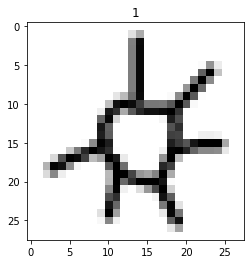

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(x_train[0], cmap='gray')
plt.title('%i' % y_train[0])
plt.show()

In [ ]:
train_dataset

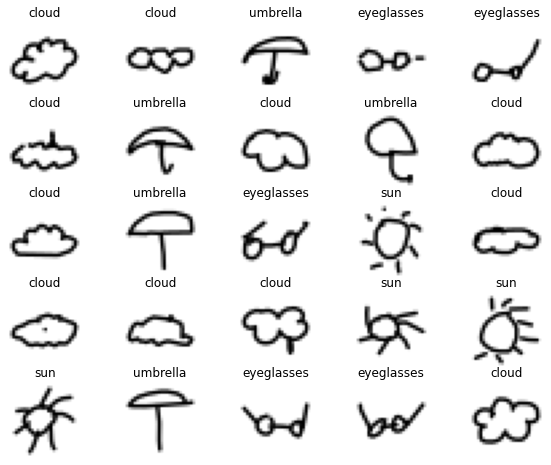

In [ ]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(x_train), size=(1,)).item()
    img = x_train[sample_idx]
    label = class_names[y_train[sample_idx].item()]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [ ]:
from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_dataset, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
}
loaders

{'test': <torch.utils.data.dataloader.DataLoader at 0x7f8c7bc09c90>,
 'train': <torch.utils.data.dataloader.DataLoader at 0x7f8c7bc09fd0>}

In [ ]:
import torch.nn as nn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, len(class_names))
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization

In [ ]:
cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=4, bias=True)
)


In [ ]:
loss_func = nn.CrossEntropyLoss()   
loss_func

CrossEntropyLoss()

In [ ]:
from torch import optim
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)   
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)

# Train and test the model:

In [ ]:
def valid_epoch(epoch):
    # Test the model
    cnn.eval()
    eval_loss = 0
    acc = 0
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
          images = images.to('cuda' if torch.cuda.is_available() else 'cpu')
          labels = labels.to('cuda' if torch.cuda.is_available() else 'cpu')
          test_output, last_layer = cnn(images.reshape((100,1, 28, 28)))
          pred_y = torch.max(test_output, 1)[1].data.squeeze()
          accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
          eval_loss += loss_func(test_output, labels).item() # sum up batch loss
          # compute number of correct predictions in the batch
          acc += correct_predictions(test_output, labels)
          pass
    
    # Average acc across all correct predictions batches now
    eval_loss /= len(loaders['test'])
    eval_acc = 100. * acc / len(loaders['test'].dataset)
    print('Eval set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        eval_loss, acc, len(loaders['test'].dataset), eval_acc,
        ))
    return eval_loss, eval_acc

In [ ]:
def train_epoch(epoch):
  cnn.train()
  losses = []
  accs = []
  for i, (images, labels) in enumerate(loaders['train']):
    # gives batch data, normalize x when iterate train_loader
    b_x = Variable(images).reshape((100,1, 28, 28))   # batch x
    b_y = Variable(labels)   # batch y
    b_x = b_x.to('cuda' if torch.cuda.is_available() else 'cpu')
    b_y = b_y.to('cuda' if torch.cuda.is_available() else 'cpu')

    # clear gradients for this training step   
    optimizer.zero_grad()

    output = cnn(b_x)[0]               
    loss = loss_func(output, b_y)
                    
    # backpropagation, compute gradients 
    loss.backward()    

    acc = 100 * (correct_predictions(output, b_y) / images.shape[0])
    losses.append(loss.item())
    accs.append(acc)
            
    # apply gradients             
    optimizer.step()                
            
    if (i) % 100 == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAcc: {:.1f}'.format(
              epoch, i * len(b_x), len(loaders['train'].dataset),
              100. * i / len(loaders['train']), loss.item(),
              acc))
        pass
    
    return np.mean(losses), np.mean(accs)



In [ ]:
from torch.autograd import Variable
num_epochs = 40

def correct_predictions(predicted_batch, label_batch):
  pred = predicted_batch.argmax(dim=1, keepdim=True) # get the index of the max log-probability
  acum = pred.eq(label_batch.view_as(pred)).sum().item()
  return acum

def train(num_epochs, cnn, loaders):

    # Train the model
    total_step = len(loaders['train'])
    tr_losses = []
    tr_accs = []
    te_losses = []
    te_accs = []
    cnn.to('cuda' if torch.cuda.is_available() else 'cpu')
    cnn.train()


    for epoch in range(1, num_epochs+1):

      # TRAIN
      loss_mean, acc_mean  = train_epoch(epoch)
      tr_losses.append(loss_mean)
      tr_accs.append(acc_mean)

      # VALIDATION
      eval_loss, eval_acc = valid_epoch(epoch)
      te_losses.append(eval_loss)
      te_accs.append(eval_acc)
      pass


    rets = {'tr_losses':tr_losses, 'te_losses':te_losses,
          'tr_accs':tr_accs, 'te_accs':te_accs}
    plt.figure(figsize=(10, 8))
    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('NLLLoss')
    plt.ylim([0, 200])
    plt.plot(tr_losses, label='train')
    plt.plot(te_losses, label='eval')
    plt.legend()
    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('Eval Accuracy [%]')
    plt.ylim([0, 100])
    plt.plot(tr_accs, label='train')
    plt.plot(te_accs, label='eval')
    plt.legend()
    pass

Train Epoch: 1 [0/64000 (0%)]	Loss: 20.736458	Acc: 22.0
Eval set: Average loss: 476.7118, Accuracy: 4448/16000 (28%)
Train Epoch: 2 [0/64000 (0%)]	Loss: 523.250061	Acc: 32.0
Eval set: Average loss: 346.0881, Accuracy: 4014/16000 (25%)
Train Epoch: 3 [0/64000 (0%)]	Loss: 378.514557	Acc: 21.0
Eval set: Average loss: 57.7748, Accuracy: 4044/16000 (25%)
Train Epoch: 4 [0/64000 (0%)]	Loss: 55.609043	Acc: 28.0
Eval set: Average loss: 1.7228, Accuracy: 4043/16000 (25%)
Train Epoch: 5 [0/64000 (0%)]	Loss: 1.736616	Acc: 24.0
Eval set: Average loss: 1.3790, Accuracy: 4341/16000 (27%)
Train Epoch: 6 [0/64000 (0%)]	Loss: 1.377502	Acc: 28.0
Eval set: Average loss: 1.7663, Accuracy: 4216/16000 (26%)
Train Epoch: 7 [0/64000 (0%)]	Loss: 1.906378	Acc: 30.0
Eval set: Average loss: 2.0316, Accuracy: 4895/16000 (31%)
Train Epoch: 8 [0/64000 (0%)]	Loss: 1.862951	Acc: 29.0
Eval set: Average loss: 2.2152, Accuracy: 5849/16000 (37%)
Train Epoch: 9 [0/64000 (0%)]	Loss: 2.131490	Acc: 48.0
Eval set: Average loss

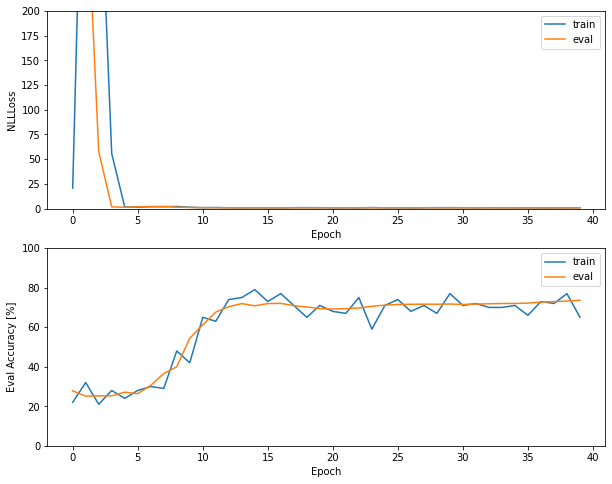

In [ ]:
train(num_epochs, cnn, loaders)

In [ ]:
sample = next(iter(loaders['test']))
imgs, lbls = sample[:50]

In [ ]:
actual_number = lbls[:50].numpy()
actual_number

array([2, 0, 1, 1, 3, 2, 2, 1, 1, 1, 3, 3, 2, 1, 3, 0, 2, 2, 1, 0, 0, 0,
       2, 3, 1, 0, 2, 3, 3, 1, 0, 1, 0, 0, 1, 3, 3, 0, 2, 1, 0, 1, 2, 0,
       0, 3, 1, 1, 3, 0], dtype=uint8)

In [ ]:
test_output, last_layer = cnn(imgs[:50].reshape((50,1, 28, 28)))
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()

In [ ]:
import pandas as pd
result = []
for i in range(0, len(actual_number)):
    result.append( [ class_names[int(actual_number[i])]  , class_names[int(pred_y[i])]])
df = pd.DataFrame(result, columns=['Target', 'Predicted'])

In [ ]:
df

,Target,Predicted
0,umbrella,umbrella
1,cloud,cloud
2,sun,sun
3,sun,cloud
4,eyeglasses,sun
5,umbrella,umbrella
6,umbrella,sun
7,sun,sun
8,sun,sun
9,sun,sun
